# importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from numpy.random import uniform
from random import sample
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

# Read the dataset

In [2]:
df = pd.read_csv("wine-clustering.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Check for null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


<AxesSubplot:>

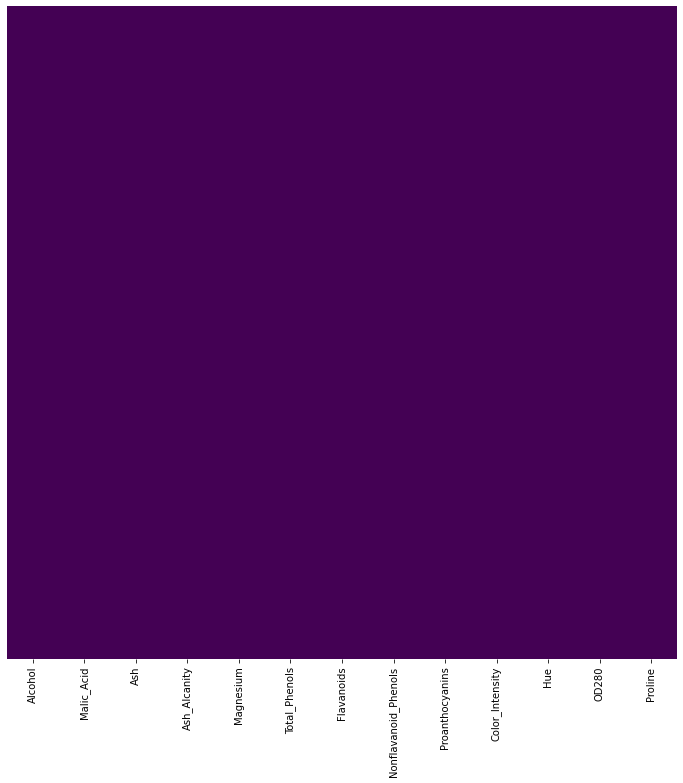

In [4]:
plt.figure(figsize=(12,12))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Check the data distribution

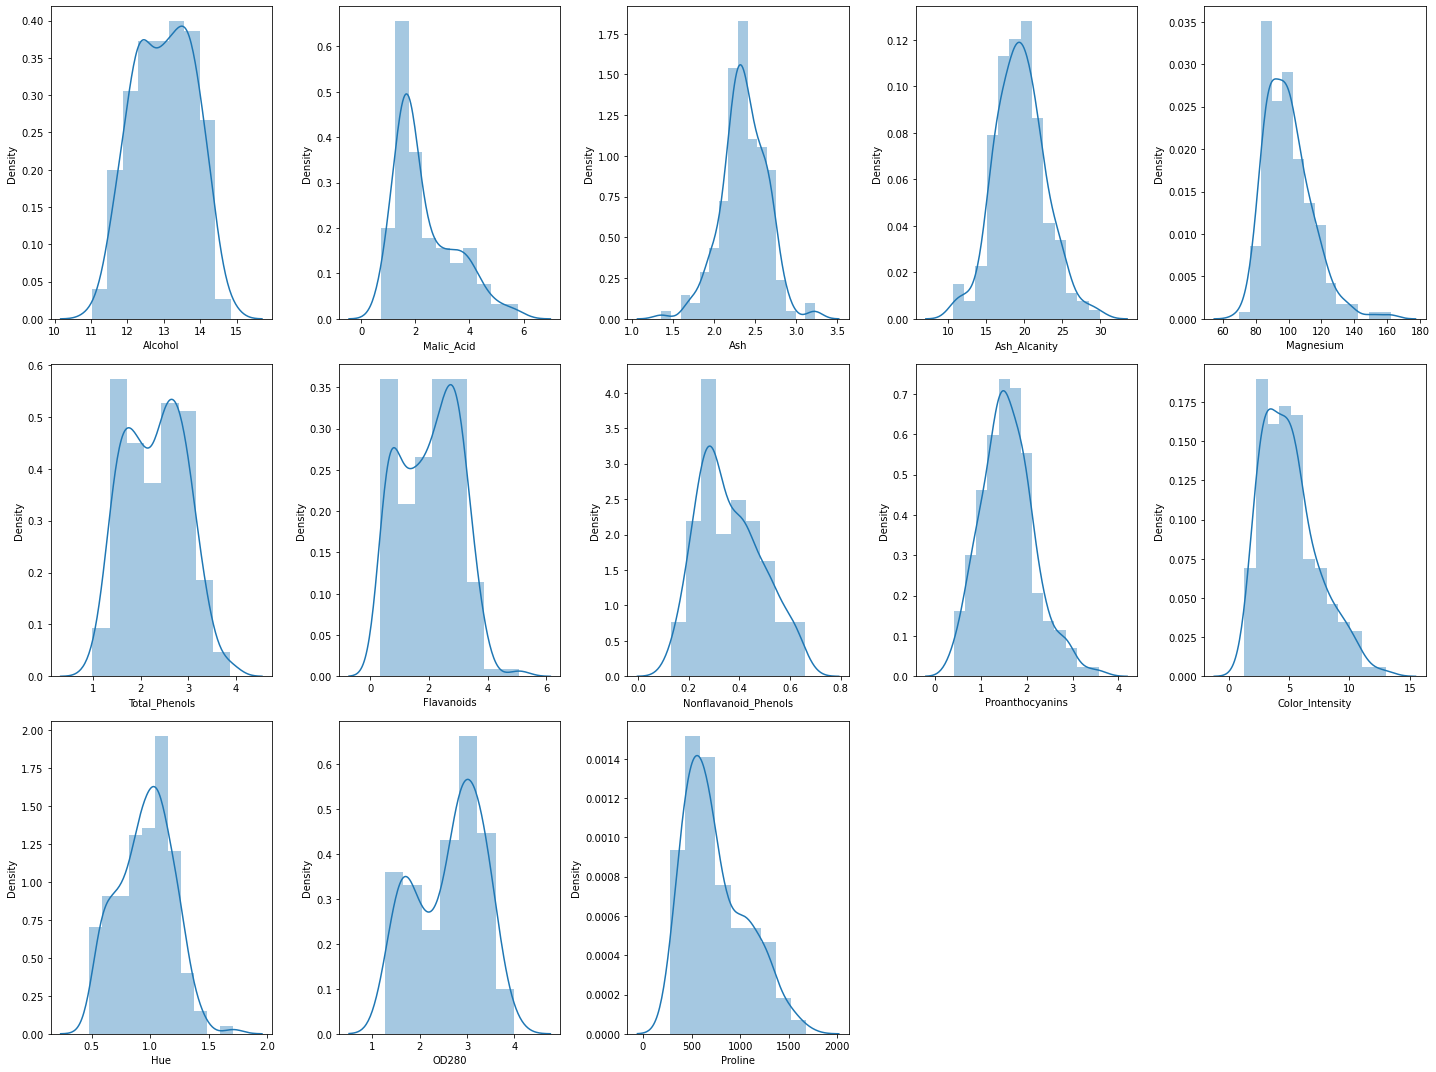

In [5]:
numeric_cols = [col for col in df.columns if df[col].dtype != 'object']
numeric_cols
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in numeric_cols:
    if plotnumber <= 13:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

# Check the correlation

<AxesSubplot:>

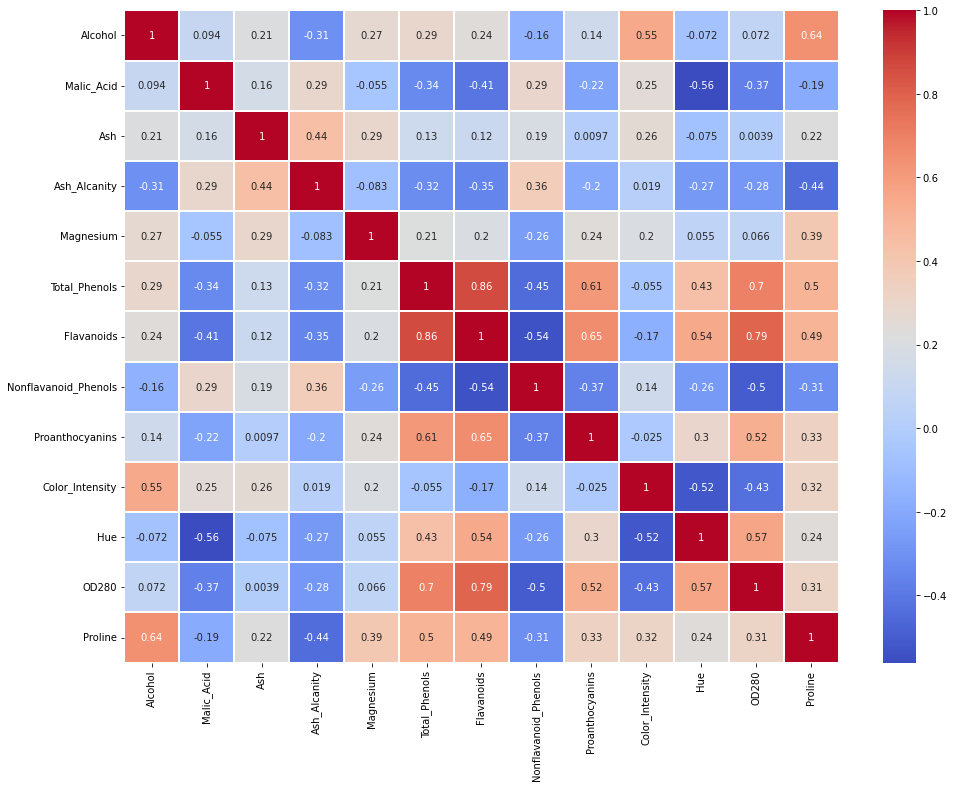

In [6]:
fig, ax = plt.subplots(figsize=(16,12))   
import seaborn as sns
sns.heatmap(df.corr(),linewidths=1.9,annot=True, cmap='coolwarm')

# Fetching features having corelation > 0.8

In [7]:

used = []
corrs = []
for i, j in enumerate(df.corr().columns):
    for k in range(len(df.corr())):
        if ((df.corr().iloc[k, i] > 0.8) & 
            (j not in used) &
            (j != df.corr().index[k])):
            
            used.append(j)
            corrs.append((j, df.corr().index[k], 
                          np.round(df.corr().iloc[k, i], 2)))

            
corrsdf = pd.DataFrame([[i[0] for i in corrs],
                        [i[1] for i in corrs],
                        [i[2] for i in corrs]])

corrsdf = corrsdf.T.rename(columns = {0:'column',1:'row',2:'corr'})
corrsdf[:20]

,column,row,corr
0,Total_Phenols,Flavanoids,0.86
1,Flavanoids,Total_Phenols,0.86


# Implementing Hopkins Statistics to test Cluster Tendency

In [8]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H
    

In [9]:
l = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(df)
    l.append(H)
#print average value:
np.mean(l)

0.6888677672547501

# Therefore, we can interpret Hopkins' statistic in the following manner:If the value is between {0.01, ...,0.3}, the data is regularly spaced.If the value is around 0.5, it is random.If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster, Here in our case it is close to 0.7

# Scaling the data

In [10]:
from sklearn.preprocessing import StandardScaler
scobj = StandardScaler()
scobj.fit(df)
scfeat = scobj.transform(df)
normalized_df = pd.DataFrame(scfeat,columns=df.columns[:])
normalized_df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


# Using Principle component Analysis to reduce the dimensionality

In [11]:
from sklearn.decomposition import PCA
pca_wine = PCA(n_components=3)
principalComponents_wine = pca_wine.fit_transform(normalized_df)
principal_wine_Df = pd.DataFrame(data = principalComponents_wine, columns = ['principal component 1', 'principal component 2','principal component 3'])
principal_wine_Df.tail()

,principal component 1,principal component 2,principal component 3
173,-3.370524,-2.216289,-0.342570
174,-2.601956,-1.757229,0.207581
175,-2.677839,-2.760899,-0.940942
176,-2.387017,-2.297347,-0.550696
177,-3.208758,-2.768920,1.013914


In [12]:
print('Explained variation per principal component: {}'.format(pca_wine.explained_variance_ratio_))

Explained variation per principal component: [0.36198848 0.1920749  0.11123631]


# 36+19+11 = 66 i.e. we are getting 66% of information from these three components


# Data distribution after Normalization

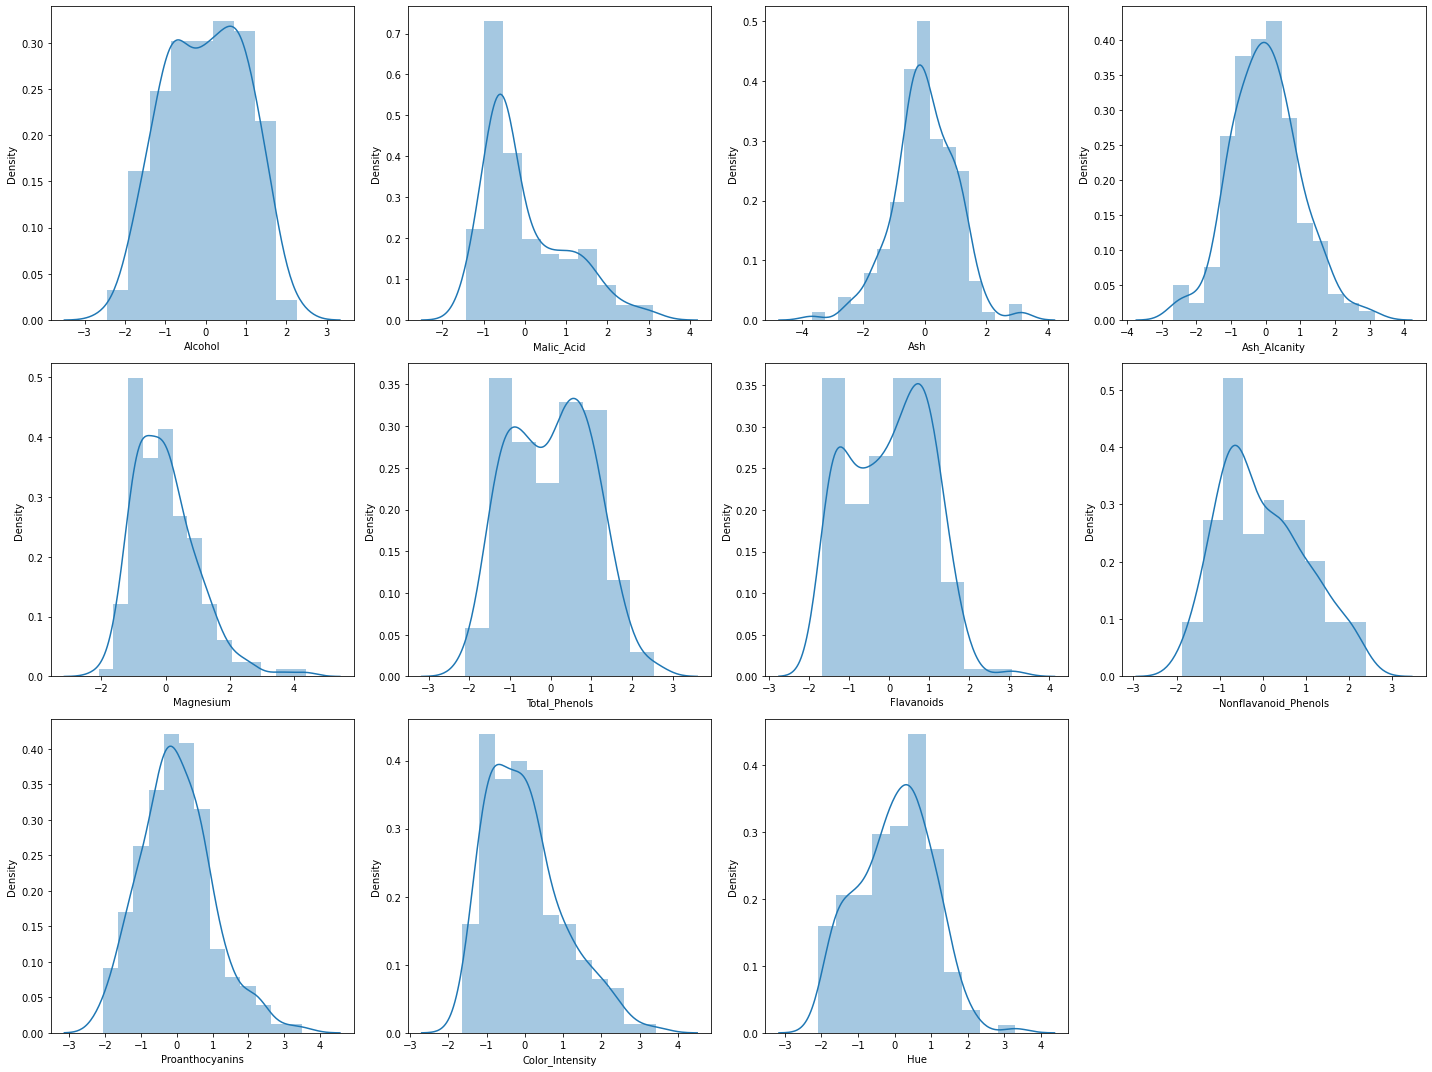

In [13]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (20, 15))
plotnumber = 1
numeric_cols = [col for col in normalized_df.columns if normalized_df[col].dtype != 'object']
for column in numeric_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.distplot(normalized_df[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

# Performing DBSCAN without any optimization ,Here by default epsilon is 0.5, and min_samples or minPoints is 5. Let’s visualize the results from this model

In [14]:
X = principal_wine_Df

In [15]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [16]:
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
def plot_dbscan():
    dbscan=DBSCAN()
    dbscan.fit(X)
    colors=['purple','red','blue','green']
    normalized_df['DBSCAN_labels']=dbscan.labels_
    # Plotting resulting clusters
    Scene = dict(xaxis = dict(title  = 'principal component 1'),yaxis = dict(title  = 'principal component 2'),zaxis = dict(title  = 'principal component 3'))
    labels = normalized_df['DBSCAN_labels']
    trace = go.Scatter3d(x=X['principal component 1'], y=X['principal component 2'], z=X['principal component 3'], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
    layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 600)
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    print("silhouette score: ",metrics.silhouette_score(X,labels))
    fig.show()

ModuleNotFoundError: No module named 'plotly'

In [17]:
plot_dbscan()

NameError: name 'plot_dbscan' is not defined

# Performing DBSCAN with optimization using K-distance graph

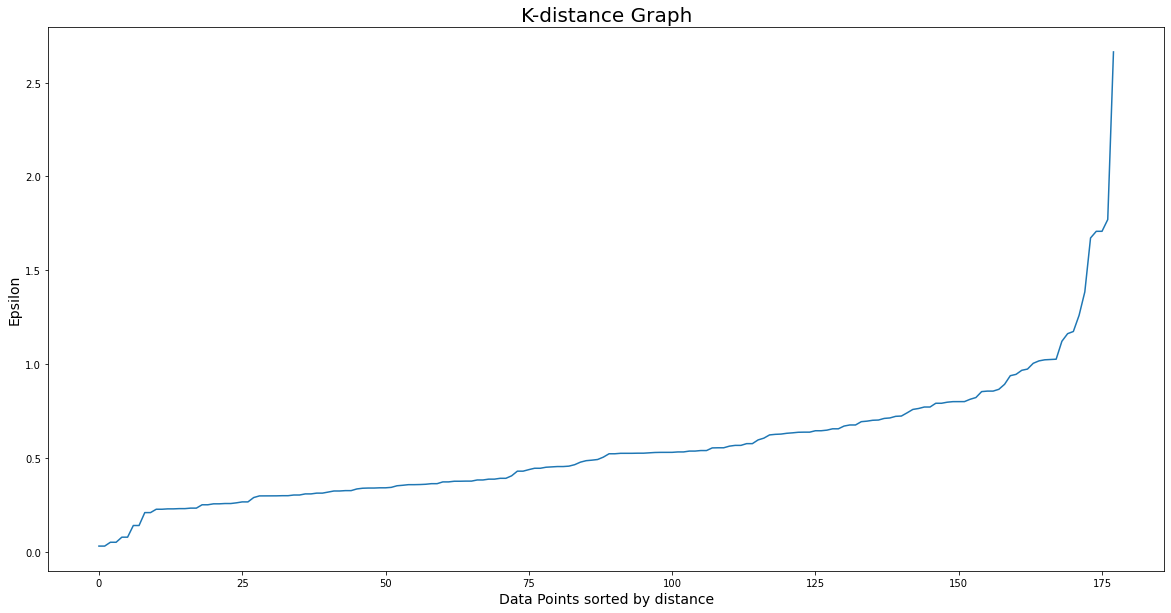

In [18]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

# The optimum value of epsilon is at the point of maximum curvature in the K-Distance Graph, which is 1.0 in this case.

In [19]:
# Deriving Minpoints
minpoints = 2*X.shape[1]
print ('Minpoints = ', minpoints)

Minpoints =  6


# Minimum number of points are 6

# Defining an optimized DBSCAN algo

In [20]:
def plot_optdbscan(eps,min_samples):
    dbscan_opt=DBSCAN(eps,min_samples)
    dbscan_opt.fit(X)
    normalized_df['DBSCAN_opt_labels']=dbscan_opt.labels_ 
    normalized_df['DBSCAN_opt_labels'].value_counts()
    Scene = dict(xaxis = dict(title  = 'principal component 1'),yaxis = dict(title  = 'principal component 2'),zaxis = dict(title  = 'principal component 3'))
    labels = normalized_df['DBSCAN_opt_labels']
    trace = go.Scatter3d(x=X['principal component 1'], y=X['principal component 2'], z=X['principal component 3'], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
    layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 600)
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    print("silhouette score: ",metrics.silhouette_score(X,labels))
    fig.show()

# Plotting three 3-dimentional graph with multiple Epsilon 

In [21]:
plot_optdbscan(1.5,6)
plot_optdbscan(1.25,6)
plot_optdbscan(1,6)

silhouette score:  0.2920822635316758


silhouette score:  0.2088911609754712


silhouette score:  0.27416089765934876


# Here we can see the data has been divided into two density clusters "White" and "Green" colours, the outliers are displayed as "Red"

In [22]:
df['Cluster'] = normalized_df['DBSCAN_opt_labels']+1
df[df['Cluster']==1].describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0
mean,12.983962,1.991698,2.353585,18.780189,99.113208,2.543113,2.523396,0.320849,1.773019,4.199906,1.048642,3.002642,808.754717,1.0
std,0.904296,0.866202,0.233981,2.704297,14.287738,0.536611,0.675410,0.098320,0.485224,1.620364,0.158251,0.438542,353.261398,0.0
min,11.410000,0.740000,1.700000,11.400000,70.000000,1.100000,0.990000,0.130000,0.410000,1.280000,0.690000,1.670000,290.000000,1.0
25%,12.227500,1.530000,2.210000,16.800000,88.000000,2.200000,2.032500,0.260000,1.442500,2.800000,0.932500,2.770000,489.750000,1.0
50%,12.990000,1.730000,2.340000,18.700000,98.000000,2.600000,2.620000,0.300000,1.695000,3.935000,1.040000,3.000000,765.000000,1.0
75%,13.767500,2.050000,2.517500,20.650000,107.000000,2.950000,3.000000,0.370000,1.987500,5.400000,1.157500,3.325000,1091.250000,1.0
max,14.830000,5.800000,2.840000,26.000000,162.000000,3.880000,3.930000,0.660000,3.580000,8.900000,1.450000,4.000000,1680.000000,1.0


# Connected the Cluster information with original Dataframe

# Interpretation: Looking at the above data summary for cluster 1 we can see that Flavanoids has Min value = 0.99 and Max value = 3.93. Similarly Cluster 2 below has Flavanoids with Min value = 0.34 and Max value = 1.59. From other data points we can observe that Cluster 1 has higher number of Flavnoids in comparison to Cluster 2. Wines having higher number of Flavanoids are good for health and heart as they act as antioxidant.

In [23]:
df[df['Cluster']==2].describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.0
mean,13.147955,3.292045,2.403182,21.063636,98.954545,1.655000,0.807727,0.443864,1.126818,7.339091,0.691136,1.701591,618.977273,2.0
std,0.466055,1.031088,0.185068,2.037222,10.916074,0.323768,0.319788,0.118875,0.364818,2.137477,0.125572,0.271498,115.464580,0.0
min,12.200000,1.240000,2.020000,16.800000,80.000000,0.980000,0.340000,0.170000,0.550000,4.000000,0.480000,1.290000,415.000000,2.0
25%,12.817500,2.587500,2.280000,19.875000,89.000000,1.407500,0.580000,0.397500,0.837500,5.487500,0.587500,1.540000,520.000000,2.0
50%,13.165000,3.265000,2.365000,21.000000,97.500000,1.635000,0.695000,0.460000,1.085000,7.450000,0.665000,1.660000,617.500000,2.0
75%,13.492500,3.885000,2.495000,22.500000,106.000000,1.800000,0.930000,0.530000,1.362500,9.082500,0.772500,1.822500,687.500000,2.0
max,14.160000,5.650000,2.860000,25.500000,123.000000,2.600000,1.590000,0.630000,2.290000,11.750000,0.980000,2.470000,855.000000,2.0


In [24]:
df[df['Cluster']==0].describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.00000,28.000000,28.000000,28.000000,28.0
mean,12.832143,2.139286,2.357857,19.735714,103.357143,2.362143,2.078214,0.388214,1.630714,4.72250,1.030714,2.561786,713.714286,0.0
std,0.853552,1.255143,0.472255,5.655624,18.371101,0.605917,1.100448,0.152171,0.732914,2.50172,0.257293,0.697743,317.366578,0.0
min,11.030000,0.900000,1.360000,10.600000,78.000000,1.380000,0.470000,0.140000,0.420000,1.90000,0.570000,1.270000,278.000000,0.0
25%,12.310000,1.235000,1.995000,15.875000,91.250000,1.900000,1.272500,0.260000,1.087500,3.30500,0.850000,1.952500,493.000000,0.0
50%,12.925000,1.755000,2.370000,18.500000,98.000000,2.300000,2.080000,0.370000,1.585000,3.82500,1.050000,2.595000,645.000000,0.0
75%,13.210000,2.612500,2.707500,25.000000,114.250000,2.740000,2.707500,0.530000,2.052500,5.47500,1.192500,3.120000,842.500000,0.0
max,14.380000,5.510000,3.230000,30.000000,151.000000,3.850000,5.080000,0.630000,2.960000,13.00000,1.710000,3.690000,1547.000000,0.0


# Above data shows the outliers